# Etude sur les PFAS (DataForGood x Generations Futures S13)
date: 12/02/2025

author: Thomas Buffet

## Cadre de l'étude
Base de données "Eau distribuée par commune" 
https://www.data.gouv.fr/fr/datasets/resultats-du-controle-sanitaire-de-leau-distribuee-commune-par-commune/

**Dans tout ce notebook, je restreins l'analyse à l'année 2024**

## C'est quoi les PFAS ?

Les substances perfluoroalkylées et polyfluoroalkylées (SPFA), plus couramment désignées sous l'acronyme de« PFAS » (de l'anglais per- and polyfluoroalkyl substances), également appelées polluants éternels du fait de leur persistance dans l’environnement, autrefois aussi dénommées composés perfluorés, sont des composés organofluorés synthétiques comportant un ou plusieurs groupes fonctionnels alkyle per- ou polyfluorés.

## Quelques ressources externes utiles
- https://www.anses.fr/fr/content/pfas-substances-chimiques-persistantes
- https://www.anses.fr/fr/system/files/SUBCHIM2009sa0331Ra-101.pdf
- https://www.anses.fr/fr/system/files/SUBSTANCES2015SA0127Ra.pdf

## Les objectifs de cette étude : 
1) identifier les composés testés qui sont des PFAS
2) identifier le nombre de prélévements, et le nombre de communes concernées. 
3) identifier les seuils existants pour chaque substance. Indiqués dans la base de donnée (seuil de qualité) mais aussi seuil toxicologiques venant de sources externes ?
4) identifier les dépassements de seuil
5) Recherche de seuils toxicologiques

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from pipelines.tasks._common import DUCKDB_FILE

# Chargement de la base de données

pd.set_option("display.max_columns", None)  # show all cols
pd.set_option("display.max_colwidth", None)  # show full width of showing cols
pd.set_option(
    "display.expand_frame_repr", False
)  # print cols side by side as it's supposed to be

con = duckdb.connect(database=DUCKDB_FILE, read_only=True)

# Objectif 1
Identifier les composés testés qui sont des PFAS

Sous objectifs
- Obtenir une liste des composés testés
- Identifier quels composés testés font partie des PFAS



### Obtenir une liste des composés testés

Joindre `edc_prelevements` et `edc_resultats` sur `referenceprel` pour obtenir les résultats associés à chaque prélèvement :

In [29]:
where_clause = """
"dateprel" >= '2024-01-01'
"""

query = f"""
SELECT
  "edc_prelevements"."referenceprel",
  "edc_prelevements"."dateprel",
  "edc_prelevements"."nomcommuneprinc",
  "edc_resultats"."libminparametre",
  "edc_resultats"."valtraduite",
  "edc_resultats"."cdunitereferencesiseeaux",
  "edc_resultats"."limitequal",
  
  
FROM (
  SELECT
    *
  FROM "edc_prelevements" 
  WHERE
    {where_clause}
) AS edc_prelevements
INNER JOIN "edc_resultats"
  ON "edc_prelevements"."referenceprel" = "edc_resultats"."referenceprel"
"""


joined = con.sql(query)
joined_df = joined.df()
joined_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
0,00100142950,2024-01-25,ANSE,Métamitrone,0.0,µg/L,"<=0,1 µg/L"
1,00100142950,2024-01-25,ANSE,Méthoxychlore,0.0,µg/L,"<=0,1 µg/L"
2,00100142950,2024-01-25,ANSE,Myclobutanil,0.0,µg/L,"<=0,1 µg/L"
3,00100142950,2024-01-25,ANSE,Sodium,19.8,mg/L,None
4,00100142950,2024-01-25,ANSE,Butyl benzène-n,0.0,µg/L,None
...,...,...,...,...,...,...,...
18774082,97400140151,2024-11-13,TAMPON (LE),Entérocoques /100ml-MS,0.0,n/(100mL),<=0 n/(100mL)
18774083,97400140151,2024-11-13,TAMPON (LE),Titre alcalimétrique,0.0,°f,None
18774084,97400140151,2024-11-13,TAMPON (LE),Température de l'eau (DOM),21.4,°C,None
18774085,97400140151,2024-11-13,TAMPON (LE),Température de mesure du pH,21.4,°C,None


In [59]:
# Obtenir une liste des composés testées (paramètre libminparametre)
noms_prelevements = joined_df.libminparametre.unique()
composes = [el for el in noms_prelevements]
print(f"{len(composes)} composés testés:\n {composes}")

1337 composés testés:
 ['Métamitrone', 'Méthoxychlore', 'Myclobutanil', 'Sodium', 'Butyl benzène-n', 'Norflurazon', 'Ammonium (en NH4)', 'Nicosulfuron', 'Nitrites (en NO2)', 'Nitrates (en NO3)', 'Nitrates/50 + Nitrites/3', 'Desmethylnorflurazon', 'Odeur (qualitatif)', 'Oxadixyl', 'Oryzalin', 'OXA alachlore', 'Oxydéméton méthyl', 'Oxadiazon', 'Oxyfluorfene', 'Parathion éthyl', 'Parathion méthyl', 'Propylbenzène-n', 'Prochloraze', 'Pentachlorophénol', 'Pseudocumène', 'Pendiméthaline', 'Total des pesticides analysés', 'pH', "pH d'équilibre à la t° échantillon", 'Phosalone', 'Pyrimicarbe', 'Piperonil butoxide', 'Propiconazole', 'Pyriméthanil', 'Prométhrine', 'Propazine', 'Prosulfuron', 'Propyzamide', 'Perméthrine', 'Prosulfocarbe', 'Pyroxsulame', 'Quimerac', 'Quinoxyfen', 'Quizalofop', 'Chlorothalonil R471811', 'Activité alpha globale en Bq/L', 'Activité béta globale en Bq/L', 'Activité béta glob. résiduelle Bq/L', 'Saveur (qualitatif)', 'Butyl benzène sec', 'Sulcotrione', 'Sélénium', 'Sim

### Identifier les PFAS (manuel)

#### Parmi les composés testés, j'en ai identifié 20 qui sont apparemment des PFAS, et un champ qui somme ces 20

In [60]:
liste_pfas = [
    "Acide perfluorobutanoïque",
    "Perfluorobutane sulfonate",
    "Acide perfluoro-decanoïque",
    "Acide perfluorododécanoique (PFDoDA)",
    "Acide perfluorododécane sulfonique (PFDoDS)",
    "Acide perfluorodecane sulfonique ",
    "Acide perfluoroheptanoïque",
    "Acide perfluoroheptane sulfonique (PFHpS)",
    "Acide perfluorohexanoïque",
    "Perfluorohexane sulfonate",
    "Acide perfluoro-nonanoïque",
    "Acide perfluorononane sulfonique (PFNS)",
    "Acide perfluoro-octanoïque",
    "Acide sulfonique de perfluorooctane",
    "Acide perfluoropentanoïque",
    "Acide perfluoropentane sulfonique (PFPS)",
    "Acide perfluoro tridecanoique (PFTrDA)",
    "Acide perfluoro tridecane sulfonique (PFTrDS)",
    "Acide perfluoro undecanoïque (PFUnA)",
    "Acide perfluoro undecane sulfonique (PFUnDS)",
]

somme_pfas = ["Somme de 20 substances perfluoroalkylées (PFAS)"]

liste_pfas_totale = liste_pfas + somme_pfas

### Bonus: pour un prélévement, vérifier si le champ "somme des 20 substances" est effectivement la somme des 20 substances 

In [61]:
# Je restreins le df aux 20 PFAS, ou à leur somme
pfas_df = joined_df[joined_df["libminparametre"].isin(liste_pfas)]
somme_pfas_df = joined_df[joined_df["libminparametre"].isin(somme_pfas)]

NB: si quelqu'un.e sait comment faire ça directement avec une query je suis preneur. Comme c'est une jointure ça ne marchait pas de mettre une condition AND libminparametre" = 'Acide perfluorobutanoïque' parce que la condition s'applique dans edc_prelevements pas dans edc_resultats.


In [63]:
# Je sélectionne un prélévement pour lequel il y a au moins une valeur non nulle
refprel = "07300251165"
pfas_df_test = pfas_df[pfas_df["referenceprel"].isin(["07300251165"])]
somme_pfas_df_test = somme_pfas_df[somme_pfas_df["referenceprel"].isin(["07300251165"])]

In [64]:
pfas_df_test

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
12949470,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorobutanoïque,0.003,µg/L,None
12949471,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Perfluorobutane sulfonate,0.002,µg/L,None
12949472,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluoro-decanoïque,0.000,µg/L,None
12949473,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorododécanoique (PFDoDA),0.000,µg/L,None
12949474,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorododécane sulfonique (PFDoDS),0.000,µg/L,None
12949475,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorodecane sulfonique,0.000,µg/L,None
12949476,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluoroheptanoïque,0.002,µg/L,None
12949477,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluoroheptane sulfonique (PFHpS),0.000,µg/L,None
12949478,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorohexanoïque,0.006,µg/L,None
12949479,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Perfluorohexane sulfonate,0.011,µg/L,None


In [65]:
somme_pfas_df_test

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
12949529,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Somme de 20 substances perfluoroalkylées (PFAS),0.04,µg/L,"<=0,1 µg/L"
12951042,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Somme de 20 substances perfluoroalkylées (PFAS),0.04,µg/L,"<=0,1 µg/L"


In [68]:
# Problème, c'est dupliqué
# Pour les 20 substances je sélectionne les 20 premiers
pfas_df_test = pfas_df_test[:20]
# Pour la somme je sélectionne les 20 premiers

somme_pfas_df_test = somme_pfas_df_test[:1]

In [69]:
pfas_df_test

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
12949470,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorobutanoïque,0.003,µg/L,None
12949471,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Perfluorobutane sulfonate,0.002,µg/L,None
12949472,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluoro-decanoïque,0.000,µg/L,None
12949473,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorododécanoique (PFDoDA),0.000,µg/L,None
12949474,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorododécane sulfonique (PFDoDS),0.000,µg/L,None
12949475,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorodecane sulfonique,0.000,µg/L,None
12949476,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluoroheptanoïque,0.002,µg/L,None
12949477,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluoroheptane sulfonique (PFHpS),0.000,µg/L,None
12949478,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Acide perfluorohexanoïque,0.006,µg/L,None
12949479,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Perfluorohexane sulfonate,0.011,µg/L,None


In [70]:
somme_pfas_df_test

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
12949529,07300251165,2024-12-04,MOTTE-SERVOLEX (LA),Somme de 20 substances perfluoroalkylées (PFAS),0.04,µg/L,"<=0,1 µg/L"


In [72]:
print(sum(pfas_df_test[:]["valtraduite"]))
print(sum(somme_pfas_df_test[:]["valtraduite"]))

0.04
0.04


## Résultats de l'objectif 1 : 
- liste de 20 substances considérées comme des PFAS : `liste_pfas`

#### Questions en suspens : 
- Est-ce qu'il y en a d'autre ? La présence du champ Somme de 20 PFAS me fait penser que non.

# Objectif 2 : identifier dans combien de communes les PFAS ont été testés

In [33]:
# Restreindre le df aux prélévements de PFAS (j'utilise le champ de la somme des 20 pfas pour aller plus vite)

somme_pfas_df = joined_df[joined_df["libminparametre"].isin(somme_pfas)]

NB: si quelqu'un.e sait comment faire ça directement avec une query je suis preneur. Comme c'est une jointure ça ne marchait pas de mettre une condition AND libminparametre" = 'Acide perfluorobutanoïque' parce que la condition s'applique dans edc_prelevements pas dans edc_resultats.


In [34]:
somme_pfas_df

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
1406,00100142957,2024-04-17,ANSE,Somme de 20 substances perfluoroalkylées (PFAS),0.0611,µg/L,"<=0,1 µg/L"
3123,00100142967,2024-01-08,ANSE,Somme de 20 substances perfluoroalkylées (PFAS),0.0728,µg/L,"<=0,1 µg/L"
11578,00100143242,2024-11-29,SERRIERES-DE-BRIORD,Somme de 20 substances perfluoroalkylées (PFAS),0.0290,µg/L,"<=0,1 µg/L"
21323,00100143331,2024-11-28,OYONNAX,Somme de 20 substances perfluoroalkylées (PFAS),0.0060,µg/L,"<=0,1 µg/L"
21421,00100143338,2024-11-20,BALAN,Somme de 20 substances perfluoroalkylées (PFAS),0.0160,µg/L,"<=0,1 µg/L"
...,...,...,...,...,...,...,...
17405748,04200192124,2024-09-26,JAS,Somme de 20 substances perfluoroalkylées (PFAS),0.0800,µg/L,"<=0,1 µg/L"
17405829,04200192124,2024-09-26,JAS,Somme de 20 substances perfluoroalkylées (PFAS),0.0800,µg/L,"<=0,1 µg/L"
18084059,07000119843,2024-10-21,SAINT-SAUVEUR,Somme de 20 substances perfluoroalkylées (PFAS),0.0010,µg/L,"<=0,1 µg/L"
18098329,07000120178,2024-11-25,FALLON,Somme de 20 substances perfluoroalkylées (PFAS),0.0040,µg/L,"<=0,1 µg/L"


In [35]:
print("J'identifie 2030 prélévements réalisés en 2024 MAIS il y a des dupliquats.")
print(
    f"Il y a {len(somme_pfas_df['referenceprel'])} entrées dans le df, mais seulement {somme_pfas_df['referenceprel'].unique().shape[0]} références de prélévements uniques"
)

J'identifie 2030 prélévements réalisés en 2024 MAIS il y a des dupliquats.
Il y a 2030 entrées dans le df, mais seulement 1426 références de prélévements uniques


In [36]:
n_communes = joined_df["nomcommuneprinc"].unique().shape[0]
n_communes_testees_pfas = somme_pfas_df["nomcommuneprinc"].unique().shape[0]
print(
    f"Les prélévements de PFAS concernent {n_communes_testees_pfas} communes sur {n_communes} ({round((n_communes_testees_pfas / n_communes) * 100, 1)}%)"
)

Les prélévements de PFAS concernent 580 communes sur 32108 (1.8%)


## Résultats Objectif 2 :
- quantification du nombre de communes concernées par les préévements de PFAS en 2024: 580 communes sur 32108 (1.8%)
- quantification incertaine du nombre de prélévements à cause de duplicats (2030 ou 1426 ?) 

#### Question restées en suspens
- question des duplicats de références de prélévements



# Objectif 3 : identifier les seuils existants pour chaque substance. 

Indiqués dans la base de donnée mais aussi seuil toxicologiques venant de sources externes ?

### Extraire de la base de données tous les prélévements pour ces 20 substances

In [37]:
pfas_df = joined_df[joined_df["libminparametre"].isin(liste_pfas)]

In [44]:
print(
    f"Les seuils indiqués pour les substances individuelles sont {pfas_df['limitequal'].unique()}.\nLes seuils indiqués pour la somme des 20 PFAS sont {somme_pfas_df['limitequal'].unique()}"
)

Les seuils indiqués pour les substances individuelles sont [None].
Les seuils indiqués pour la somme des 20 PFAS sont ['<=0,1 µg/L']




## Résultats Objectif 3:
- Identification d'un seuil dans la base de données pour la somme de 20 PFAS: >=0.1 µg/L
- Pas de seuils indiqués pour les substances individuelles

**NB**
Cette limite de 0.1µg/L est expliquée ici :

https://www.anses.fr/fr/content/pfas-substances-chimiques-persistantes

"Le suivi des PFAS dans les eaux de boisson a été introduit par la directive européenne 2020/2184 du 16 décembre 2020 relative à la qualité des eaux destinées à la consommation humaine (EDCH). Ainsi, à ce jour, une limite de qualité de 0,10 µg/L a été fixée pour la somme de 20 PFAS dans les EDCH. Un autre paramètre, intitulé « PFAS (total) », est également introduit avec une limite de qualité associée de 0,50 µg/L : il vise à intégrer l’ensemble des PFAS mesurables dans l’eau.

Cette directive a été transposée en droit français en janvier 2023. L’arrêté du 11 janvier 2007 modifié intègre la limite de qualité de 0,1 µg/L pour les 20 PFAS et la recherche systématique des PFAS sera intégrée au contrôle sanitaire des EDCH par les Agences régionales de santé à partir du 1er janvier 2026. Toutefois, depuis le 1er janvier 2023, toute situation de dépassement de la nouvelle limite de qualité mise en évidence doit être prise en compte."

#### Question restées en suspens
- Où trouver des valeurs limites toxicologiques pour chacune de ces substances ?

# Objectif 4 : identifier les dépassements de seuil



Combien y a-t-il eu de dépassement de seuil pour la somme des 20 PFAS en 2024 ?

In [46]:
somme_pfas_depassement_df = somme_pfas_df[somme_pfas_df["valtraduite"] >= 0.1]

In [47]:
somme_pfas_depassement_df

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
828359,03800338369,2024-02-19,TERNAY,Somme de 20 substances perfluoroalkylées (PFAS),0.135,µg/L,"<=0,1 µg/L"
935279,03800340130,2024-11-15,CHASSE-SUR-RHONE,Somme de 20 substances perfluoroalkylées (PFAS),0.141,µg/L,"<=0,1 µg/L"
978060,03800341213,2024-12-18,SAINT-QUENTIN-FALLAVIER,Somme de 20 substances perfluoroalkylées (PFAS),0.107,µg/L,"<=0,1 µg/L"
979503,03800341213,2024-12-18,SAINT-QUENTIN-FALLAVIER,Somme de 20 substances perfluoroalkylées (PFAS),0.107,µg/L,"<=0,1 µg/L"
1229589,04100107087,2024-06-26,VENDOME,Somme de 20 substances perfluoroalkylées (PFAS),0.110,µg/L,"<=0,1 µg/L"
...,...,...,...,...,...,...,...
12885908,06900166074,2024-08-26,TERNAY,Somme de 20 substances perfluoroalkylées (PFAS),0.115,µg/L,"<=0,1 µg/L"
12945289,07300251043,2024-12-04,CHAMBERY,Somme de 20 substances perfluoroalkylées (PFAS),0.110,µg/L,"<=0,1 µg/L"
15940300,08900130113,2024-03-22,MONT-SAINT-SULPICE,Somme de 20 substances perfluoroalkylées (PFAS),0.100,µg/L,"<=0,1 µg/L"
16632435,01300272708,2024-11-04,FOS-SUR-MER,Somme de 20 substances perfluoroalkylées (PFAS),0.433,µg/L,"<=0,1 µg/L"


In [74]:
somme_pfas_depassement_df["referenceprel"].unique().shape[0]

134

**NB** ici aussi j'ai des problèmes de duplicats (entrées de df avec la même valeurs de `referenceprel`, et toutes les autres valuers aussi identiques)

In [82]:
# Je supprime les duplicats de referenceprel
somme_pfas_depassement_df.drop_duplicates(subset="referenceprel")

,referenceprel,dateprel,nomcommuneprinc,libminparametre,valtraduite,cdunitereferencesiseeaux,limitequal
828359,03800338369,2024-02-19,TERNAY,Somme de 20 substances perfluoroalkylées (PFAS),0.135,µg/L,"<=0,1 µg/L"
935279,03800340130,2024-11-15,CHASSE-SUR-RHONE,Somme de 20 substances perfluoroalkylées (PFAS),0.141,µg/L,"<=0,1 µg/L"
978060,03800341213,2024-12-18,SAINT-QUENTIN-FALLAVIER,Somme de 20 substances perfluoroalkylées (PFAS),0.107,µg/L,"<=0,1 µg/L"
1229589,04100107087,2024-06-26,VENDOME,Somme de 20 substances perfluoroalkylées (PFAS),0.110,µg/L,"<=0,1 µg/L"
1267156,04100108079,2024-09-26,VENDOME,Somme de 20 substances perfluoroalkylées (PFAS),0.100,µg/L,"<=0,1 µg/L"
...,...,...,...,...,...,...,...
12848031,06900168149,2024-12-16,TERNAY,Somme de 20 substances perfluoroalkylées (PFAS),0.161,µg/L,"<=0,1 µg/L"
12945289,07300251043,2024-12-04,CHAMBERY,Somme de 20 substances perfluoroalkylées (PFAS),0.110,µg/L,"<=0,1 µg/L"
15940300,08900130113,2024-03-22,MONT-SAINT-SULPICE,Somme de 20 substances perfluoroalkylées (PFAS),0.100,µg/L,"<=0,1 µg/L"
16632435,01300272708,2024-11-04,FOS-SUR-MER,Somme de 20 substances perfluoroalkylées (PFAS),0.433,µg/L,"<=0,1 µg/L"


Text(0, 0.5, 'Nombre de prélévements')

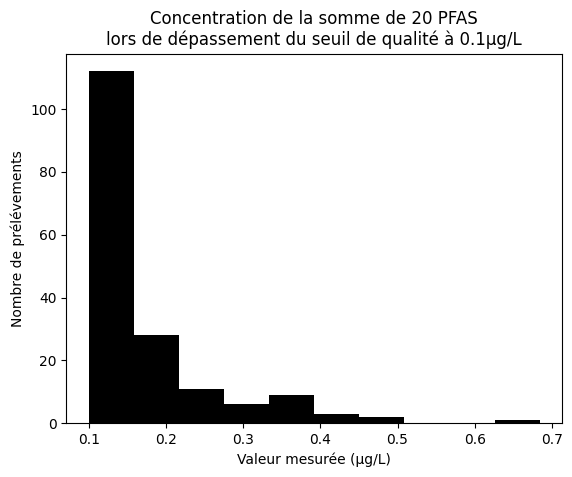

In [83]:
plt.figure()
plt.hist(somme_pfas_depassement_df["valtraduite"], color="k")
plt.title(
    "Concentration de la somme de 20 PFAS\nlors de dépassement du seuil de qualité à 0.1µg/L"
)
plt.xlabel("Valeur mesurée (µg/L)")
plt.ylabel("Nombre de prélévements")

## Résultats Objectif 4:
- Il y a eu 134 dépassements de seuil (sur 1426 prélévements)

#### Questions restées en suspens
- Est-ce que supprimer les duplicats était la bonne chose à faire ?
- Qu'est-ce que ça signifie en terme de dangerosité ? Identifier des seuils toxicologiques substance par substance ?

# Objectif 5


L'ANSES a produit un rapport sur l'élaboration de valeurs de référence chroniques par voie orale pour les composés perfluorés suivants :
- l’acide perfluorohexanoïque (PFHxA, CAS n° 307-24-4)
- l’acide perfluorohexane sulfonique (PFHxS, CAS n°355-46-4)
- l’acide perfluorobutanoïque (PFBA, CAS n°375-22-4)
 -l’acide perfluorobutane sulfonique (PFBS, CAS n°375-73-5). 

"Ces quatre composés perfluorés ont donc fait l’objet de travaux distincts dans l’objectif de leur attribuer des valeurs toxicologique de référence (VTR). " (P.5 du rapport)

"Une VTR est un indice toxicologique qui permet de qualifier ou de quantifier un risque pour la 
santé humaine. Elle établit le lien entre une exposition à une substance toxique et l’occurrence 
d’un effet sanitaire indésirable."

Ces quatre PFAS sont présents dans notre liste de 20 PFAS testés dans l'eau ! (composés 0, 1, 6 et 7 dans la liste)



**Acide perfluorobutanoïque (PFBA)**

effet critique = effet hépatique

détermination d'une VTi (différent de la VTR)

VTi = 0.024mg/kg/j

Comment relier cette valeur en mg/kg/j à la valeur en µg/L de notre base de données ?

**Acide perfluorohexane sulfonique (PFHxS)**

effet critique = effet hépatique

détermination d'une VTi (différent de la VTR)

VTi = 0.004mg/kg/j

Comment relier cette valeur en mg/kg/j à la valeur en µg/L de notre base de données ?

**Acide perfluorobutane sulfonique (PFBS)**

effet critique = effet sur le rein

VTR = 0.08mg/kg/j

Comment relier cette valeur en mg/kg/j à la valeur en µg/L de notre base de données ?

**Acide perfluorohexanoïque (PFHxA)**

effet critiques = effet sur le foie et le rein

VTR = 0.32mg/kg/j

Comment relier cette valeur en mg/kg/j à la valeur en µg/L de notre base de données ?

### Proposition de lien entre ces deux valeurs (avec les pieds...)

En prenant l'hypothèse d'un individu de m=60kg buvant V=2L d'eau par jour
Prenont l'exemple de l'Acide perfluorobutane sulfonique 

VTR = 0.08 mg/kg/j

VTR = 0.08 * 60 / 2 mg/L

VTR = 2.4 mg/L

VTR = 2400 µg/L

Le seuil toxicologique à dépasser serait donc très élevé par rapport à la valeur de limite de qualité de 0.1µg/L

Avec un produit dangereux à des concentrations plus faibles (Acide perfluorohexane sulfonique) et un individu de 50kg buvant 4L d'eau par jour

VTi = 0.004mg/kg/j

VTi = 4µg/kg/j

VTi = 4 * 50 / 4 µg/L

VTi = 50 µg/L


### Quelle est la plus haute mesure d'Acide perfluorohexane sulfonique ?

In [97]:
PFHxS_df = pfas_df[pfas_df["libminparametre"] == "Perfluorohexane sulfonate"]
max(PFHxS_df["valtraduite"])

print(
    f"La plus haute concentration de Perfluorohexane sulfonate mesurée en 2024 est {max(PFHxS_df['valtraduite'])}µg/L, très inférieure à la valeur de VTi = 50 µg/L"
)

La plus haute concentration de Perfluorohexane sulfonate mesurée en 2024 est 0.073µg/L, très inférieure à la valeur de VTi = 50 µg/L


## Résultats Objectif 5:
- Identification de seuils toxicologiques (VTR et VTi) pour 4 PFAS dans un rapport de l'ANSES.

#### Questions restées en suspens
- Pertinence de la démarche ? Est-ce que c'est intéressant d'aller chercher ces seuils pour les 16 autres substances ?
- Comment faire le lien entre ces valeurs de VTR ou VTi en mg/kg/j et les valeurs mesurées en µg/L ? Quelle est la pertinence du calcul proposé ?